# Transform transmission to Fluxes in LSST

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : December 15th 2021

# imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
from astropy.table import Table

In [4]:
from scipy.stats import rayleigh,beta,gamma,uniform

In [5]:
from scipy import interpolate

In [6]:
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [7]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

In [8]:
import scipy.special as sp

In [9]:
PATH_LSSTFiltersKG='../../data/lsst/LSSTFiltersKG'
sys.path.append(PATH_LSSTFiltersKG)
PATH_LSSTFiltersKGDATA='../../data/lsst/LSSTFiltersKG/fdata'
sys.path.append(PATH_LSSTFiltersKGDATA)

In [10]:
import libLSSTFiltersKG as lsst

liblsstfilter_path= ../../data/lsst/LSSTFiltersKG


In [11]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser

# Pre defined Functions

In [12]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

## Functions to select the CALSPEC

In [13]:
def GetListOfCalspec(file_sedsummary="sed/table_summary_allcalspec_torenorm.fits"):
    """
    GetListOfCalspec()
    
    the file include SED fro which color term has been caculated 
    in /examples_sed/calspec/ViewCalspecColors.ipynb
    
    - input:
      file_sedsummary : filename of SED summary
      
    - output:
      t : astropy table of summary 
    """

    t=Table.read(file_sedsummary)
    return t

In [14]:
def SelectFewSED(t):
    """
    SelectFewSED(t)
    
    input : 
     - t astropy table of SED
     
    output :
    - t_selected : table of presselected SED
     
    """
    
    all_colors=t["VmI"]
    
    
    # list of target colors
    target_VmI=np.array([-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
    NBVmItarget=len(target_VmI)
    
    filesselected_index=np.zeros(NBVmItarget)
    filesselected_VmI=np.zeros(NBVmItarget)
    
    idx=0
    for vmi in target_VmI:
        thevmi,theidx=find_nearest(all_colors,vmi)
        #print(thevmi,theidx)
        filesselected_index[idx]=int(theidx)
        filesselected_VmI[idx]=thevmi
        idx+=1  
        
    t_selected=Table(t[0])
    for idx in filesselected_index[1:]:
        t_selected.add_row(t[int(idx)])
        
    return t_selected
    

In [15]:
def plot_sed(t,ax):
    """
    
    plot_sed(t, ax) : Plot SED from the astropy table t

    input:
        - t : tables of SED
        - ax : matplotlib axis

    """
    
    NBFILES=len(t)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)
    
    idx=0
    
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')

    for filename in t["FILES"]:
    
        # read the calspec file
        fullfilename=os.path.join(path_sed_calspec,filename)
        print("filename = ",filename,"fullfilename = ", fullfilename)
        
        if filename=="flat":
            spec=flatsp
            spec_norm=spec
        else:
            spec=S.FileSpectrum(fullfilename)
        
        spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
        spec_norm.convert('photlam')
        #spec_norm.convert('nm')    
        
        #WLMINSEL=340.
        #WLMAXSEL=1100.


        magV=t["magV"][idx]
        label=t["OBJNAME"][idx]+" ( "+t["SP_TYPE"][idx]+" ) "+" magV = {:.2g}".format(magV) +" v-i ={:.2f}".format(t["VmI"][idx])
        
        
        
        #X= spec_norm.wave[wavelengths_indexes]    
        #Y= spec_norm.flux[wavelengths_indexes]  
        
        X= spec_norm.wave   
        Y= spec_norm.flux 
        
        wavelengths_indexes=np.where(np.logical_and(spec_norm.wave>WLMINSEL*10, spec_norm.wave<WLMAXSEL*10))[0]
        
        
        #if filename!="flat":
        cm=ax.plot(X[wavelengths_indexes], Y[wavelengths_indexes],color=all_colors[idx],label=label)
        
        idx+=1
    
    #ax.set_xlim(3500.,11000.)
    #ax.set_ylim(0.,3.)
    ax.legend()
    ax.grid()


    xlabel=' $\\lambda$ (Angstrom)'
    ylabel=' Flux (photlam) normalised to Mag-10'
    ax.set_xlabel(xlabel,fontsize=15)
    ax.set_ylabel(ylabel,fontsize=15)
    ax.set_title("Preselected CALSPEC relative SED")
    
    return cm

    
    

## Functions to build spectrum 

In [16]:
def GetSpectra(sed,wl_atm,atm_transmission):
    """
    
    * input : 
     - sed : Pysynphot SED
     -  wl  : wavelength of the atmospheric transmission (nm)
     - transmission : atmospheric transmission array
    
    * output :
     - array of spectra (corresponding to wl in nm)
    
    """
    
    wl0=sed.wave  # in angstrom
    spectra=np.zeros_like(atm_transmission)
   
    wl_atm_ang=10*wl_atm
    
    # Passband for filters
    datafilename = "../../data/lsst/filters/transmissions-LSST.dat"
    df=pd.read_csv(datafilename,names=['wl','Topt','Tccd','U','G','R','I','Z','Y4','atm'],sep='\t')
    
    wl=df['wl'].values
    U=df['U'].values/100.
    G=df['G'].values/100.
    R=df['R'].values/100.
    I=df['I'].values/100.
    Z=df['Z'].values/100.
    Y4=df['Y4'].values/100.
    
    
    all_bp_filters = []
    all_bp_filters.append(S.ArrayBandpass(wl*10, U , name="u"))
    all_bp_filters.append(S.ArrayBandpass(wl*10, G , name="g"))
    all_bp_filters.append(S.ArrayBandpass(wl*10, R , name="r"))
    all_bp_filters.append(S.ArrayBandpass(wl*10, I , name="i"))
    all_bp_filters.append(S.ArrayBandpass(wl*10, Z , name="y"))
    all_bp_filters.append(S.ArrayBandpass(wl*10, Y4 , name="y"))
    NFILTER=len(all_bp_filters)
    
    
    # passband for atmosphere
    NATM=atm_transmission.shape[0]
    all_bp_atm=[]
    
    for i_atm in np.arange(NATM):
        label_atm="atm{:d}".format(i_atm)
        bp_atm= S.ArrayBandpass(wl_atm_ang,atm_transmission[i_atm,:], name=label_atm)
        all_bp_atm.append(bp_atm)
        
        
    # produce all observation
    all_obs        = []
    all_obs_interp = []
    # loop on filter
    for ifilter in range(NFILTER):    
        all_obs_filter = [] # initialize all observation in that filter
        all_obs_filter_interp = [] # initialize all interpolated observation in that filter
        # loop on atmosphere
        for i_atm in np.arange(NATM):
            # multiply filter by atmosphere
            bp_all = all_bp_filters[ifilter]*all_bp_atm[i_atm]
            obs = S.Observation(sed, bp_all,force='taper') 
            all_obs_filter.append(obs) # pile up obs
            
            # interpolation
            func_flux = interpolate.interp1d(obs.binwave,obs.binflux,bounds_error=False,fill_value=(0,0))
            spectrum=func_flux(wl_atm_ang) 
            all_obs_filter_interp.append(spectrum)
        
        all_obs.append(all_obs_filter) # cumulate all observations for each filter
        all_obs_interp.append(all_obs_filter_interp)
   
    
    return all_obs ,all_obs_interp 
    
    

In [17]:
if 0:
    spectra,spectra_interp=GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm[:22,:]);
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(111)
    for idx in np.arange(20):
        ax.plot(wl,spectra_interp[0][idx],'b-')
        ax.plot(wl,spectra_interp[1][idx],'g-')
        ax.plot(wl,spectra_interp[2][idx],'r-')
        ax.plot(wl,spectra_interp[3][idx],'-',color="orange")
        ax.plot(wl,spectra_interp[4][idx],'k-')
        ax.plot(wl,spectra_interp[5][idx],'-',color="grey")
    


# GetAtmTransparency

In [18]:
def GetAtmTransparency(inputdir,filelist):
    """
    GetAtmTransparency(inputdir, filelist): retrieve atmospheric transparency from simulation

    input arguments:
     - inputdir : input directory
     - filelist : list of file to read
    """
    
    filename=filelist[0]
    full_inputfilename=os.path.join(inputdir,filename)
    hduin = fits.open(full_inputfilename)
    
    headerin=hduin[0].header
    datain=hduin[0].data
    
    hdr=headerin
    NSIMH=hdr['NBATMSIM']
    idx_num = hdr['ID_NUM']
    idx_am = hdr['ID_AM']
    idx_vaod=hdr['ID_VAOD']
    idx_pwv= hdr['ID_PWV']
    idx_o3=hdr['ID_O3']
    idx_cld=hdr['ID_CLD']
    idx_res= hdr['ID_RES']
    
    wl=datain[0,idx_res:]
    
    hduin.close() 
    
    all_data=[]
    # loop on files to extract data
    for file in filelist:
        full_inputfilename=os.path.join(inputdir,file)
        hdu = fits.open(full_inputfilename)
       
        datain=hdu[0].data
        all_data.append(datain[1:,:])
        hdu.close
        
    dataout=np.concatenate(all_data,axis=0)
    
    return wl,dataout,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,headerin
        

# Initialisation

In [19]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)


#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))

LA time: 11:42:45
NY time: 14:42:45
London time: 19:42:45
Paris time: 20:42:45


# Configuration

In [20]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')


In [21]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2021-12-15 20:42:45,643 MacBook-Pro-de-admin.local __main__[78308] INFO LA time:11:42:45
2021-12-15 20:42:45,644 MacBook-Pro-de-admin.local __main__[78308] INFO NY time:14:42:45
2021-12-15 20:42:45,646 MacBook-Pro-de-admin.local __main__[78308] INFO London time:19:42:45
2021-12-15 20:42:45,647 MacBook-Pro-de-admin.local __main__[78308] INFO Paris time:20:42:45
2021-12-15 20:42:45,648 MacBook-Pro-de-admin.local __main__[78308] INFO ************************ START *********************


In [22]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""

In [23]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2021-12-15 20:42:45,673 MacBook-Pro-de-admin.local __main__[78308] INFO Configuration file : config/default.ini


In [24]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2021-12-15 20:42:45,687 MacBook-Pro-de-admin.local __main__[78308] INFO 1) Configuration


In [25]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [26]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT = bool(int(config['GENERAL']['FLAG_PRINT']))
else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

if 'SIMTRANSMTOFLUXLSST' in config_section:
    input_file = config['SIMTRANSMTOFLUXLSST']['inputfile']
    input_dir = config['SIMTRANSMTOFLUXLSST']['inputdir']

    packetsize = int(config['SIMTRANSMTOFLUXLSST']['packetsize'])
    maxnbpacket = int(config['SIMTRANSMTOFLUXLSST']['maxnbpacket'])

    input_file_split=input_file.split(".")    
    basefilename=input_file_split[0]
    extendfilename=input_file_split[1]
else:
    msg="Configuration file : Missing section SIMTRANSMTOFLUXLSST in config file {config_filename} !"
    logger.error(msg)
    
    
if 'LSST' in config_section:

    WLMIN      = float(config['LSST']['WLMIN'])
    WLMAX      = float(config['LSST']['WLMAX'])
    SEFF       = float(config['LSST']['SEFF'])
    DEFF       = float(config['LSST']['DEFF']) 
    EXPOSURE   = float(config['LSST']['EXPOSURE']) 
    GEL        = float(config['LSST']['GEL']) 
    SIG_INST   = float(config['LSST']['SIG_INST'])
    PIXSCALE   = float(config['LSST']['PIXSCALE']) 
    NFILTERS   = int(config['LSST']['NFILTERS']) 
    SKY_BACKGROUND_MAG = config['LSST']['SKY_BACKGROUND_MAG'] 
    FWHM_SEEING_ARCSEC = config['LSST']['FWHM_SEEING_ARCSEC']



In [27]:
print(SKY_BACKGROUND_MAG)
print(FWHM_SEEING_ARCSEC)

22.92,22.27,21.20,20.47,19.59,18.64
.77,.73,.7,0.67,0.65,0.63


In [28]:
SKY_BACKGROUND_MAG_N = [ float(x) for x in SKY_BACKGROUND_MAG.split(",") ]
SKY_BACKGROUND_MAG_N 

[22.92, 22.27, 21.2, 20.47, 19.59, 18.64]

In [29]:
FWHM_SEEING_ARCSEC_N = [ float(x) for x in FWHM_SEEING_ARCSEC.split(",") ]
FWHM_SEEING_ARCSEC_N

[0.77, 0.73, 0.7, 0.67, 0.65, 0.63]

In [30]:
NBINS = int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth = (WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL = np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

S.refs.setref(area = SEFF, waveset=None) # set by default to 324015.4546769212 cm2
S.refs.set_default_waveset(minwave = WLMIN, maxwave = WLMAX, num = NBINS, delta = BinWidth, log = False)
S.refs.showref()

graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


# Atmospheric transparency file and selection

In [31]:
all_files = os.listdir(input_dir)
sorted_files=sorted(all_files)

In [32]:
# search string
search_str="^"+f"{basefilename}.*fits$"

In [33]:
selected_files=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_files.append(file)

### Keep a limited number of input files

In [34]:
if maxnbpacket>0:
    selected_files=selected_files[:maxnbpacket]

In [35]:
NFiles=len(selected_files)

### Keep one file only

In [36]:
ifile=1

In [37]:
selected_files= [ selected_files[ifile] ]

# Read simulated atmospheric transparency

In [38]:
wl,datain,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,header=GetAtmTransparency(input_dir,selected_files)

In [39]:
logger.info(header)

2021-12-15 20:42:45,816 MacBook-Pro-de-admin.local __main__[78308] INFO SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  957                                                  NAXIS2  =                  101                                                  NBATMSIM=                20000                                                  ID_NUM  =                    0                                                  ID_AM   =                    1                                                  ID_VAOD =                    2                                                  ID_PWV  =                    3                                                  ID_O3   =                    4                                                  ID_CLD  =                    5                  

In [40]:
idx_cld

5

In [41]:
num=datain[0:,idx_num]
airmass=datain[0:,idx_am]
vaod=datain[0:,idx_vaod] # vertical aerosol depth
pwv=datain[0:,idx_pwv]   # precipitable water vapor (mm)
ozone=datain[0:,idx_o3]     # ozone
cld=datain[0:,idx_cld]   # clouds (not us

In [42]:
transm=datain[:,idx_res:]

In [43]:
wl.shape

(951,)

In [44]:
transm.shape

(100, 951)

2021-12-15 20:42:46,439 MacBook-Pro-de-admin.local matplotlib.legend[78308] WARNING No handles with labels found to put in legend.


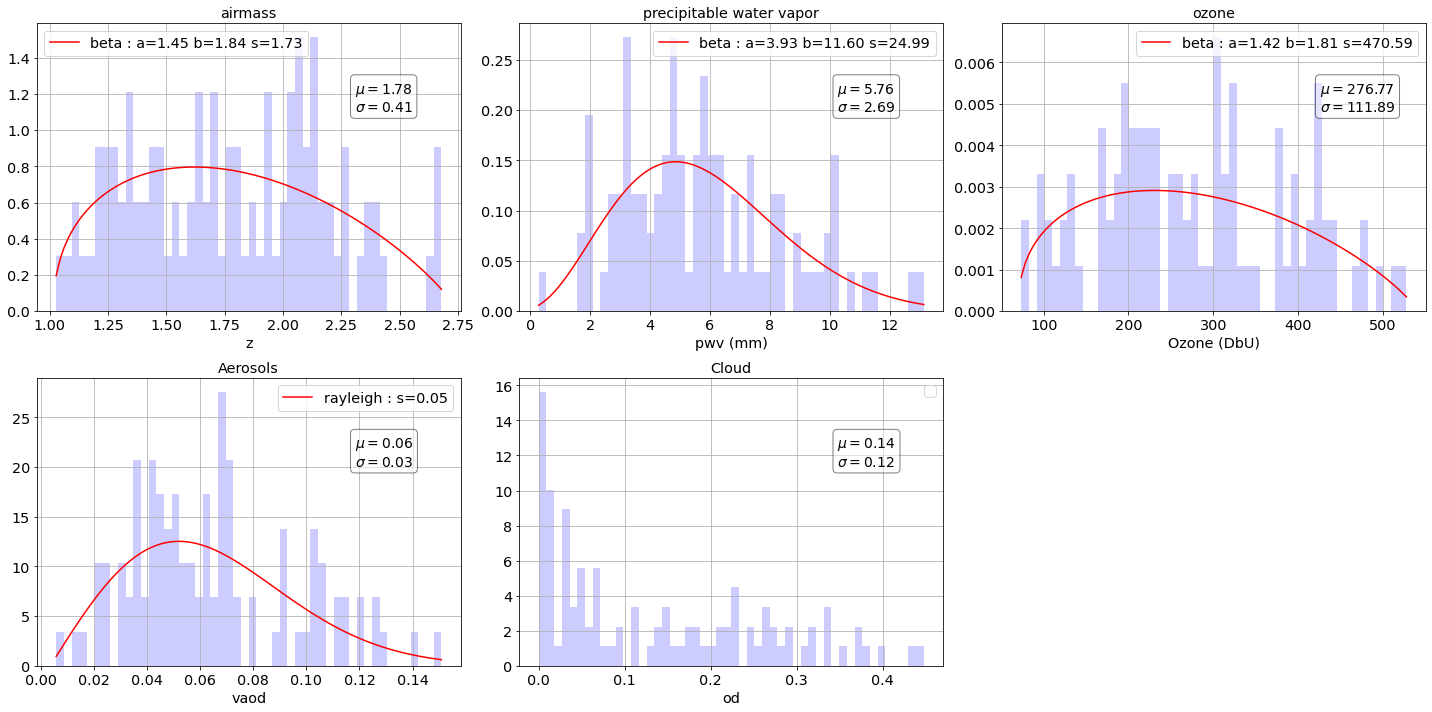

In [45]:
def GetDistribFromName(name):
    """
    
    GetDistribFromName(name): Get distribution from name in config file
    
    input arg:
    
    - name : string name of the distribution
    
    """
    
    rayleigh,beta,gamma,uniform
    
    if name=="rayleigh":
        return rayleigh
    elif name=="beta":
        return beta
    elif name=="gamma":
        return gamma
    else:
        return uniform
    


if FLAG_PLOT:
    fig=plt.figure(figsize=(20,10))
    ax1=fig.add_subplot(231)
    ax2=fig.add_subplot(232)
    ax3=fig.add_subplot(233)
    ax4=fig.add_subplot(234)
    ax5=fig.add_subplot(235)
    #ax6=fig.add_subplot(326)

    # -----------------  airmass
    mu=np.average(airmass)
    sigma=np.std(airmass)
    ax1.hist(airmass,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax1.set_title("airmass")
    ax1.set_xlabel("z")
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))


    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax1.text(0.75, 0.8, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    
    
    if 'AIRMASS' in config_section:
        distrib_name= config['AIRMASS']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(airmass)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(airmass.min(),airmass.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        ax1.plot(x,pdf,"r-",label=label)
        ax1.legend()
        ax1.grid()
    
    #----------------pwv--------------------
    
    mu=np.average(pwv)
    sigma=np.std(pwv)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    ax2.hist(pwv,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax2.set_title("precipitable water vapor")
    ax2.set_xlabel("pwv (mm)")
    
    ax2.text(0.75, 0.8, textstr, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    if 'PWV' in config_section:
        distrib_name= config['PWV']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(pwv)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(pwv.min(),pwv.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax2.plot(x,pdf,"r-",label=label)
        ax2.legend()
        ax2.grid()
    
        
    #-------------- Ozone
    
    mu=np.average(ozone)
    sigma=np.std(ozone)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    ax3.hist(ozone,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax3.set_title("ozone")
    ax3.set_xlabel("Ozone (DbU)")
    
    ax3.text(0.75, 0.8, textstr, transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    
    if 'OZONE' in config_section:
        distrib_name= config['OZONE']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(ozone)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(ozone.min(),ozone.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax3.plot(x,pdf,"r-",label=label)
        ax3.legend()
        ax3.grid()
    
    
    #-------------------- VAOD
    
    mu=np.average(vaod)
    sigma=np.std(vaod)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    ax4.hist(vaod,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax4.set_title("Aerosols")
    ax4.set_xlabel("vaod")
    
    ax4.text(0.75, 0.8, textstr, transform=ax4.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    
    if 'AEROSOL' in config_section:
        distrib_name= config['AEROSOL']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(vaod)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(vaod.min(),vaod.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        ax4.plot(x,pdf,"r-",label=label)
        ax4.legend()
        ax4.grid()
    
    #-------------- clouds
    
    mu=np.average(cld)
    sigma=np.std(cld)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    
    ax5.hist(cld,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax5.set_title("Cloud")
    ax5.set_xlabel("od")
    
    ax5.text(0.75, 0.8, textstr, transform=ax5.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    
    if 'CLOUD' in config_section:
        distrib_name= config['CLOUD']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(cld)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(cld.min(),cld.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        #ax5.plot(x,pdf,"r-",label=label)
        ax5.legend()
        ax5.grid()
        
        
    plt.tight_layout()

### Select wavelength range

Truncate wavelength

In [46]:
WLMINSEL=300.
WLMAXSEL=1100.

In [47]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [48]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [49]:
wl=wl[indexes_selected]
transm_tot=transm[:,indexes_selected]

In [50]:
transm=transm_tot

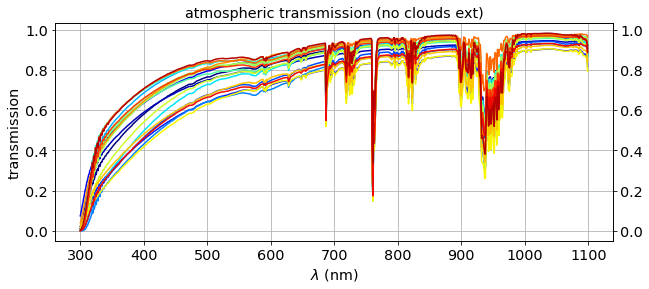

In [51]:
if FLAG_PLOT:
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    fig=plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    for idx in np.arange(N):
        ax.plot(wl,transm[idx,:],c=all_colors[idx])
        
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("transmission")
    ax.set_title("atmospheric transmission (no clouds ext)")
    ax.grid()
        
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    #ax1.grid()
    

In [52]:
NWL=wl.shape[0]

In [53]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# SED

In [54]:
t=GetListOfCalspec()
t

OBJNAME,RA,DEC,SP_TYPE,SP_QUAL,magU,magB,magV,magR,magI,FILES,calcU,calcB,calcV,calcR,calcI,factor,VmI
bytes10,float64,float64,bytes12,bytes1,float64,float32,float64,float64,float64,bytes27,float64,float64,float64,float64,float64,float64,float64
NGC7293,337.411,-20.837,DAO.5,C,11.894,13.158,13.524,13.689,13.898,ngc7293_005.fits,11.917,13.180,13.538,13.734,14.234,26.01,-0.697
FEIGE67,190.466,17.522,sdOpec,D,10.261,11.700,11.630,11.969,12.159,feige67_002.fits,10.256,11.478,11.811,11.987,12.463,5.3027,-0.652
GD50,57.209,-0.976,DA1.2,C,12.596,13.787,14.063,14.210,14.388,gd50_004.fits,12.674,13.817,14.043,14.217,14.674,41.416,-0.631
FEIGE66,189.348,25.067,sdB1(k),C,9.117,10.260,10.590,10.642,10.809,feige66_002.fits,9.123,10.225,10.487,10.642,11.096,1.5662,-0.609
GD108,150.197,-7.559,sdB,D,12.406,13.349,13.563,13.662,13.781,gd108_005.fits,12.412,13.347,13.558,13.659,14.073,26.488,-0.516
G93-48,328.106,2.389,DA2.8,C,11.942,12.732,12.743,12.839,12.938,g93_48_004.fits,11.982,12.717,12.728,12.836,13.234,12.34,-0.506
HZ2,63.181,11.864,DA2.3,C,12.903,13.787,13.877,13.984,14.094,hz2_005.fits,12.943,13.792,13.849,13.949,14.339,34.649,-0.490
HZ44,200.897,36.133,sdBN0VIIHe28,B,10.186,11.420,11.650,12.000,11.995,hz44_stis_004.fits,10.212,11.389,11.653,11.826,12.110,4.5833,-0.458
HZ21,183.484,32.942,DO1,C,13.125,14.361,14.688,14.837,15.038,hz21_stis_004.fits,13.134,14.356,14.678,14.848,15.132,74.303,-0.454


In [55]:
t_sel=SelectFewSED(t)

In [56]:
t_sel

OBJNAME,RA,DEC,SP_TYPE,SP_QUAL,magU,magB,magV,magR,magI,FILES,calcU,calcB,calcV,calcR,calcI,factor,VmI
bytes10,float64,float64,bytes12,bytes1,float64,float32,float64,float64,float64,bytes27,float64,float64,float64,float64,float64,float64,float64
NGC7293,337.411,-20.837,DAO.5,C,11.894,13.158,13.524,13.689,13.898,ngc7293_005.fits,11.917,13.180,13.538,13.734,14.234,26.01,-0.697
G93-48,328.106,2.389,DA2.8,C,11.942,12.732,12.743,12.839,12.938,g93_48_004.fits,11.982,12.717,12.728,12.836,13.234,12.34,-0.506
HZ4,58.842,9.788,DA3.4,C,13.917,14.592,14.506,14.580,14.642,hz4_stis_005.fits,13.961,14.593,14.473,14.569,14.723,61.551,-0.250
ALPHA_LYR,279.235,38.784,A0Va,C,0.030,0.030,0.030,0.070,0.100,alpha_lyr_stis_008.fits,0.021,0.017,0.009,0.000,-0.004,0.00010079,0.013
HD163466,268.106,60.396,A2,E,100000000000000000000.000,7.040,6.850,100000000000000000000.000,100000000000000000000.000,hd163466_stis_004.fits,7.161,7.036,6.839,6.694,6.589,0.054409,0.251
HD074000,130.212,-16.345,F2,D,9.840,10.090,9.660,100000000000000000000.000,100000000000000000000.000,hd074000_stis_003.fits,9.852,10.065,9.645,9.269,8.987,0.72107,0.658
HD106252,183.373,10.042,G0,E,100000000000000000000.000,8.000,100000000000000000000.000,7.000,100000000000000000000.000,hd106252_stis_004.fits,8.117,8.020,7.403,6.957,6.653,0.091453,0.750
FLAT,0.000,0.000,flat,0,9.721,10.369,10.000,9.501,9.001,flat,9.721,10.369,10.000,9.501,9.001,1,0.999


### Show examples of SED to use

filename =  ngc7293_005.fits fullfilename =  /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/ngc7293_005.fits


2021-12-15 20:42:49,481 MacBook-Pro-de-admin.local astropy[78308] WARNING VerifyWarning: Invalid keyword for column 1: Column disp option (TDISPn) failed verification: Format 26A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2021-12-15 20:42:49,486 MacBook-Pro-de-admin.local astropy[78308] WARNING VerifyWarning: Invalid keyword for column 2: Column disp option (TDISPn) failed verification: Format 18A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2021-12-15 20:42:49,493 MacBook-Pro-de-admin.local astropy[78308] WARNING VerifyWarning: Invalid keyword for column 3: Column disp option (TDISPn) failed verification: Format 56A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2021-12-15 20:42:49,499 MacBook-Pro-de-admin.local astropy[78308] WARNING VerifyWarning: Invalid keyword for column 4: Column disp option (

filename =  g93_48_004.fits fullfilename =  /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/g93_48_004.fits
filename =  hz4_stis_005.fits fullfilename =  /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hz4_stis_005.fits
filename =  alpha_lyr_stis_008.fits fullfilename =  /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/alpha_lyr_stis_008.fits
filename =  hd163466_stis_004.fits fullfilename =  /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd163466_stis_004.fits
Warning, 44 of 7210 bins contained negative fluxes; they have been set to zero.
filename =  hd074000_stis_003.fits fullfilename =  /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd074000_stis_003.fits
filename =  hd106252_stis_004.fits fullfilename =  /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd106252_stis_004.fits
Warning, 19 of 6265 bins contained negative fluxes; they have been set to zero.
filename =  flat fullf

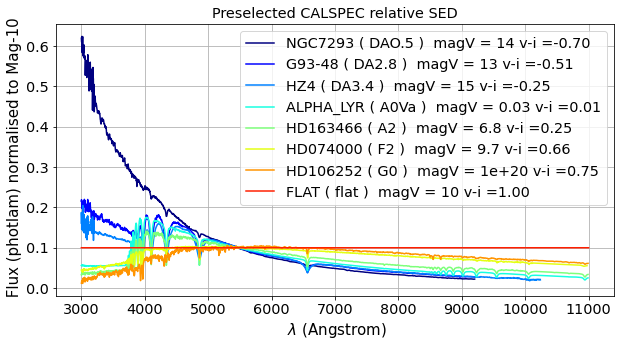

In [57]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    plot_sed(t_sel,ax)
    plt.show()

### Extract a row as a table

In [58]:
# Extract vega row
t_vega_row = t_sel[3]

In [59]:
# create the astropy table with the format of the table row above
t_vega_table=Table(names=t_vega_row.colnames)

In [60]:
# create the new table from the vega row
t_vega_table=Table(t_vega_row)

filename =  alpha_lyr_stis_008.fits fullfilename =  /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/alpha_lyr_stis_008.fits


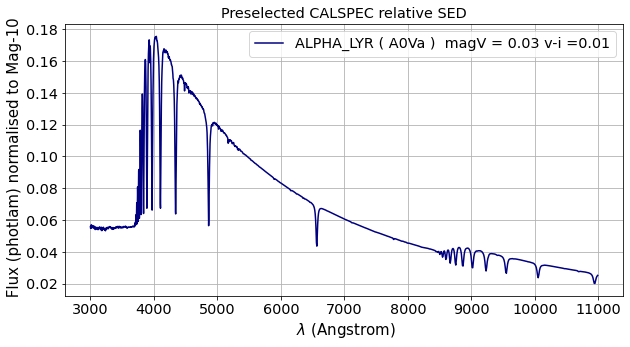

In [61]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    plot_sed(t_vega_table,ax)
    plt.show()

### Get the Spectrum

In [62]:
idx_sed_sel=3
sed_filename=t_sel[idx_sed_sel]["FILES"]
sed_objname=t_sel[idx_sed_sel]["OBJNAME"]
sed_fullfilename=os.path.join(path_sed_calspec,sed_filename)

In [63]:
if sed_filename=="flat":
    flatsp = S.FlatSpectrum(20, fluxunits='photlam')
    spec=flatsp
else:
    spec=S.FileSpectrum(sed_fullfilename)
        
spec_norm = spec.renorm(20, 'vegamag', S.ObsBandpass('johnson,v'))
    
spec_norm.convert('photlam')

In [64]:
#spectra,spectra_interp=GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm[:50,:]);
spectra,spectra_interp=GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm[:,:]);

((u * atm0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm8)) does not have a defined binset in the wavecat table. The wa

((u * atm70)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm71)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm72)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm73)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm74)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm75)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm76)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm77)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * atm78)) does not have a defined binset in the wavecat tabl

((g * atm40)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm41)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm42)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm43)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm44)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm45)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm46)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm47)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atm48)) does not have a defined binset in the wavecat tabl

((r * atm10)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm11)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm18)) does not have a defined binset in the wavecat tabl

((r * atm80)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm81)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm82)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm83)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm84)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm85)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm86)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm87)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atm88)) does not have a defined binset in the wavecat tabl

((i * atm50)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm51)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm52)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm53)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm54)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm55)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm56)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm57)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atm58)) does not have a defined binset in the wavecat tabl

((y * atm20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm26)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm27)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm28)) does not have a defined binset in the wavecat tabl

((y * atm90)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm91)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm92)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm93)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm94)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm95)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm96)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm97)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm98)) does not have a defined binset in the wavecat tabl

((y * atm60)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm61)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm62)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm63)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm64)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm65)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm66)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm67)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atm68)) does not have a defined binset in the wavecat tabl

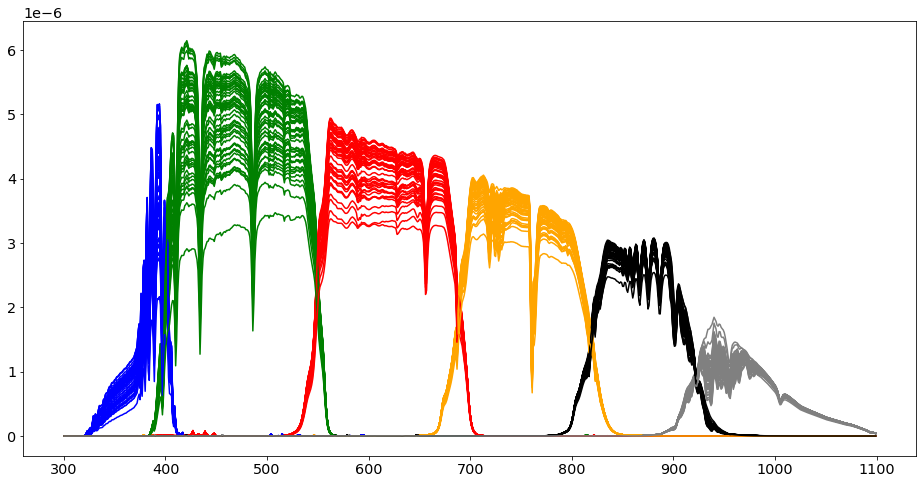

In [65]:

if 1:
    fig=plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    for idx in np.arange(50):
        ax.plot(wl,spectra_interp[0][idx],'b-')
        ax.plot(wl,spectra_interp[1][idx],'g-')
        ax.plot(wl,spectra_interp[2][idx],'r-')
        ax.plot(wl,spectra_interp[3][idx],'-',color="orange")
        ax.plot(wl,spectra_interp[4][idx],'k-')
        ax.plot(wl,spectra_interp[5][idx],'-',color="grey")
    
